In [42]:
using CSV, DataFrames
using FileIO, Dates
using Graphs, MetaGraphs
using DataStructures
using PyCall
using CairoMakie

include("./src/cubes.jl")
include("./src/network.jl")

@pyimport powerlaw as powlaw

In [43]:
region = "japan"
# multiplier = [1.0,1.0,1.0]

"japan"

In [47]:
# Select 3 of the best cell sizes from parameter dependency analysis
if region == "romania"
    cell_sizes = [3.5,  4.5,  5.5];
    # minimum_magnitudes = [0,1,2,3];
    multiplier = [0.7,1.0,1.3]
elseif region == "california"
    cell_sizes = [1.0, 1.5, 2.0];
    # minimum_magnitudes = [2,3];
    multiplier = [0.7,1.0,1.3]
elseif region == "italy"
    cell_sizes = [4.0, 5.0, 6.0];
    multiplier = [0.4,1.0,1.8]
    # minimum_magnitudes = [2,3];
elseif region == "japan"
    cell_sizes = [2.5, 3.5, 5.0];
    multiplier = [0.4,1.0,1.8]
    # minimum_magnitudes = [2,3,4,5];
end;
# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);
magnitude_threshold = 0.0

# Make path for results
mkpath("./results/$region")

    

"./results/japan"

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


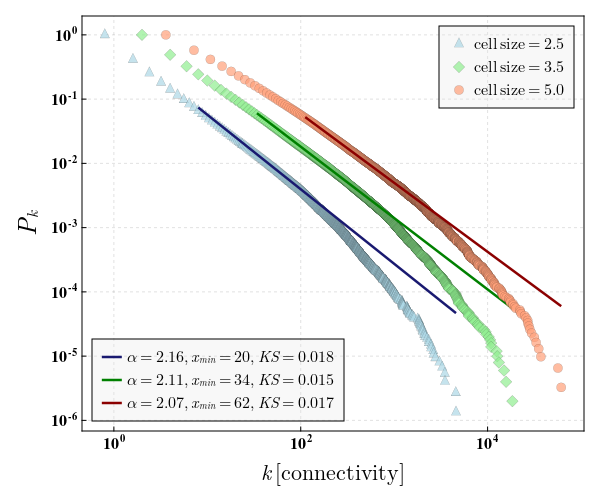

In [48]:
set_theme!(Theme(fonts=(; regular="CMU Serif Bold")))
fig1 = Figure(resolution = (600, 500), font= "CMU Serif") 
ax1 = Axis(fig1[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

sc1 = Array{Any,1}(undef,3)

for i in eachindex(cell_sizes)
    df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
    MG = create_network(df, df_cubes)
    degrees=[]
    for i in 1:nv(MG)
        push!(degrees, get_prop(MG, i, :degree))
    end

    # Powerlaw Fit
    fit = powlaw.Fit(degrees);
    alpha = round(fit.alpha, digits=2)
    xmin = Int(round(fit.xmin, digits=2))
    KS = round(fit.power_law.KS(data=degrees), digits=3)

    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    ########################################### ALL
    # CCDF of all data scattered 
    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)


    sc1[i] = scatter!(ax1, multiplier[i] .* x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    ln = lines!(ax1, multiplier[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label= L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)",
    color=line_colors[i], linewidth=2.5, strokewidth=5) 


end

# Top right, cell size legend
axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], [L"\text{cell\,size}=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], position = :rt, bgcolor = (:grey90, 0.25));
# Bottom left, results legend
axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25));


# # Save both plots
save( "./results/$region/$(region)_minmag_$(magnitude_threshold)_best_fits_all_data.png", fig1, px_per_unit=5)
fig1
